### Examples with different tasks using different response formats

##### The helper function: (as seen in "APIgettingstarted.ipynb")

In [24]:
import requests
import matplotlib.pyplot as plt
%notebook inline

In [2]:
def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"e74bff8a3f17fa1497eb8c11243b2b87"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
         return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

Task 1: for Illustris-1 at z=0, get all the fields available for the subhalo with id=0 and print its total mass and stellar half mass radius

In [3]:
url = "http://www.tng-project.org/api/Illustris-1/snapshots/135/subhalos/0/"
r = get(url)
r['mass']

22174.8

In [4]:
r['halfmassrad_stars']

72.0388

Task 2: for Illustris-1 at z=2, search for all subhalos with total mass 10^11.9 M_o < M < M^12.1 M_o, print the number returned, and find the Subfind IDs of the first five results (arbitrarily ordered, you may get different ids).

In [5]:
# first convert log solar masses into group catalog units
mass_min = 10**11.9 / 1e10 * 0.704
mass_max = 10**12.1 / 1e10 * 0.704

In [6]:
# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)
search_query

'?mass__gt=55.920707724589455&mass__lt=88.6283489903093'

In [53]:
# form the url and make the request
url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + search_query
subhalos = get(url)
print(subhalos['count'])
print(list(subhalos))

550
['count', 'next', 'previous', 'results']


In [54]:
ids = [subhalos['results'][i]['id'] for i in range(5)]
ids

[1, 1352, 5525, 6574, 12718]

Task 3: for Illustris-1 at z=2, retrieve all fields for five specific Subfind IDs (from above), print the stellar mass and number of star particles in each.

In [56]:
ids = [1, 1352, 5525, 6574, 12718]
for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + str(id)
    subhalo = get(url)
    print("ID:", id, "Stellar mass:", subhalo['mass_stars'], "Num of Stars:", subhalo['len_stars'])

ID: 1 Stellar mass: 3.44785 Num of Stars: 54286
ID: 1352 Stellar mass: 3.14618 Num of Stars: 47648
ID: 5525 Stellar mass: 2.93244 Num of Stars: 45252
ID: 6574 Stellar mass: 3.73319 Num of Stars: 58277
ID: 12718 Stellar mass: 3.77762 Num of Stars: 57532


Task 5: for Illustris-1 at z=2, for five specific Subfind IDs (from before), extract and save full cutouts from the snapshot (HDF5 format).

In [47]:
ids = [16522, 17000, 17001, 20095, 20096]
for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + str(id) + "/cutout.hdf5"
    saved_filename = get(url)
    print(id, saved_filename)

16522 cutout_16522.hdf5
17000 cutout_17000.hdf5
17001 cutout_17001.hdf5
20095 cutout_20095.hdf5
20096 cutout_20096.hdf5


Task 6: for Illustris at z=2, for Subfind ID 1, get a cutout including only the positions and metallicities of stars, and calculates the mean stellar metallicity in solar units within the annuli 3kpc < r < 5kpc (proper) centered on the fiducial subhalo position

In [20]:
import h5py
import numpy as np

id = 6574
redshift = 2.0
params = {'stars:''Coordinates, GFM_Metallicity'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127

url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5") # get and save HDF5 cutout file
# ok so the site has "saved_filename = get(url + "/cutout.hdf5", params)" but i got an error so let's assume this works just the same

with h5py.File(saved_filename) as f:
    # NOTE! If the subhalo is near the edge of the box, you must take the periodic boundary into account! (we ignore it here)
    dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
    metals = f['PartType4']['GFM_Metallicity'][:]
    
    rr = np.sqrt(dx**2 + dy**2 + dz**2)
    rr *= scale_factor/little_h # ckpc/h -> physical kpc
    
    w = np.where( (rr >= 3.0) & (rr < 5.0) )    
    print(np.mean(metals[w] ) / solar_Z)

1.5702679401307595


Task 8: for Illustris-1 at z=2, for five specific Subfind IDs (from before), locate the z=0 descendant of each by using the API to walk down the SubLink descendant links 

In [21]:
z0_descendant_ids = [-1]*len(ids)

for i,id in enumerate(ids):
    start_url = "http://www.tng-project.org/api/Illustris-1/snapshots/68/subhalos/" + str(id)
    sub = get(start_url)
    
    while sub['desc_sfid'] != -1:
        # request the full subhalo details of the descendant by following the sublink URL
        sub = get(sub['related']['sublink_descendant'])
        if sub['snap'] == 135:
            z0_descendant_ids[i] = sub['id']
        
    if z0_descendant_ids[i] >= 0:
        print('Descendant of ' + str(id) + ' at z=0 is ' + str(z0_descendant_ids[i]))
    else:
        print('Descendant of ' + str(id) + ' not followed to z=0!')

Descendant of 1 at z=0 is 30465
Descendant of 1352 at z=0 is 41396
Descendant of 5525 at z=0 is 99148
Descendant of 6574 at z=0 is 51811
Descendant of 12718 at z=0 is 194303


Task 9: for Illustris at z=2, track Subfind ID 1 to z=0, using the API to walk down the SubLink descendant links, and plot the mass evolution of each component (gas, dark matter, stars, and black holes).

/home/desi/anaconda3/envs/legacyhalos/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


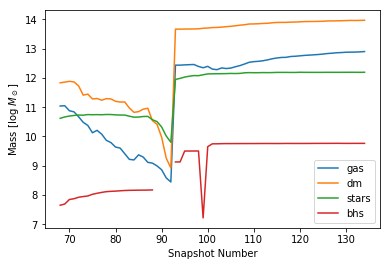

In [29]:
id = 5525
url = "http://www.tng-project.org/api/Illustris-1/snapshots/68/subhalos/" + str(id)
sub = get(url) # get json response of subhalo properties

# prepare dict to hold result arrays
fields = ['snap','id','mass_gas','mass_stars','mass_dm','mass_bhs']
r = {}
for field in fields:
    r[field] = []

while sub['desc_sfid'] != -1:
    for field in fields:
        r[field].append(sub[field])
    # request the full subhalo details of the descendant by following the sublink URL
    sub = get(sub['related']['sublink_descendant'])
    
# make a plot (notice our subhalo falls into a much more massive halo around snapshot 105)
for partType in ['gas','dm','stars','bhs']:
    mass_logmsun = np.log10( np.array(r['mass_'+partType])*1e10/0.704)
    plt.plot(r['snap'],mass_logmsun,label=partType)
 
    plt.xlabel('Snapshot Number')
    plt.ylabel('Mass [log $M_\odot$]')
    plt.legend(loc='lower right');


Task 10: for Illustris at z=0, check if pre-rendered mock stellar images exist for five Subfind IDs (the descendants from above). If so, download and display the PNGs.

In [39]:
import matplotlib.image as mpimg
from io import StringIO

ids = [30465,41396,99148,51811,194303]

sub_count = 5525
plt.figure(figsize=[15,3])

for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/135/subhalos/" + str(id)
    sub = get(url)
     
    # it is of course possible this data product does not exist for all requested subhalos
    if'stellar_mocks' in sub['supplementary_data']: 
        # download PNG image, the version which includes all stars in the FoF halo (try replacing 'fof' with 'gz')
        png_url = sub['supplementary_data']['stellar_mocks']['image_fof']
        response = get(png_url)
         
        # make plot a bit nicer
        plt.subplot(1,len(ids),sub_count)
        plt.text(0,-20,"ID="+str(id),color='blue')
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        sub_count += 1
         
        # plot the PNG binary data directly, without actually saving a .png file
        file_object = StringIO(response.content)
        plt.imshow(mpimg.imread(file_object))

TooManyRedirects: Exceeded 30 redirects.

<Figure size 1080x216 with 0 Axes>

Task 11: download the entire Illustris-1 z=0 snapshit including only the positions, masses, and metallicities of stars

In [42]:
base_url = "http://www.illustris-project.org/api/Illustris-1/"
sim_metadata = get(base_url)
params = {'stars': 'Coordinates, Masses, GFM_Metallicity'}

for i in range(sim_metadata['num_files_snapshot']):
    file_url = base_url + "files/snapshot-135." + str(i) + ".hdf5"
    saved_filename = get(file_url, params)
    print(saved_filename)

HTTPError: 400 Client Error: Bad Request for url: http://www.illustris-project.org/api/Illustris-1/files/snapshot-135.0.hdf5?stars=Coordinates%2C+Masses%2C+GFM_Metallicity